# Project Description: 
The following is the code used in the making of a MANU465 Capstone Project for Group 40. The entirety of the code and the data used throughout this project is available at [this github repo](https://github.com/Koi199/Machine-Learning-scripts/tree/main/EEG%20Project).

## Authors

| Names         | Student Numbers |
|---------------|-----------------|
| Kyle Ah Von   | 57862609        |
| Sean Lim      | 67591842        |
| Sammy Lin     | 40808107        |
| Kezmen Chen   | 18302984        |

## Brainwave Analysis for Tactile Stimuli Classification Using Machine Learning

In this project, we utilized an EEG device to measure brainwave responses to various tactile stimuli, including soft touch, hard touch, hand touch, and no touch. The goal was to analyze the impact of these stimuli on brainwave patterns and classify the responses using machine learning techniques.

We preprocessed the EEG data to remove noise and artifacts, extracted relevant features, and trained a machine learning model to identify and predict the type of tactile stimulus based on the recorded brainwave activity. This work contributes to understanding the neural correlates of touch and has potential applications in neuroscience research, human-computer interaction, and rehabilitation therapy.

**Key Technologies:**

EEG Device (Muse 2): For collecting brainwave data.

Python: For data processing and machine learning implementation.

Machine Learning Models: Classification algorithms like Random Forest, Support Vector Machines, and Neural Networks.

Libraries: TensorFlow, Scikit-learn.

This project demonstrates the intersection of neuroscience and machine learning, emphasizing the application of AI in cognitive and sensory studies.

## Challenges
1. Small sample set
2. Sampling frequency tuning 
3. Potential Overfitting during classification

## Recommendation
Collect data on more random participants over a couple months and introduce better rest/baseline measurements. 

# General Setup
## Importing Libraries

In [603]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as kr
import seaborn as sns
import os

## Import Raw Data
Process folder tree structure

In [604]:
# Function to extract files and append labels to csv files

def combine_csvs_with_labels(base_dir, output_file):
    """
    Combines all CSV files in subfolders of 'base_dir' into a single CSV.
    Extracts the label from the folder name, which is the suffix after the last dash.

    Parameters:
    - base_dir: Path to the main directory (e.g., 'Dataset').
    - output_file: Path to the output combined CSV file.
    """
    combined_data = []  # List to store data from all CSV files
    
    # Traverse through all subdirectories and files
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.csv'):  # Process only CSV files
                # Extract the label from the folder name
                folder_name = os.path.basename(root)
                label = folder_name.split('-')[-1]  # Get the suffix as the label
                
                # Full path to the current CSV file
                csv_path = os.path.join(root, file)
                
                # Read the CSV file
                try:
                    df = pd.read_csv(csv_path)
                    df['label'] = label  # Add a new column for the label
                    combined_data.append(df)
                except Exception as e:
                    print(f"Error reading {csv_path}: {e}")
                    continue
    
    # Combine all the data into a single DataFrame
    if combined_data:
        combined_df = pd.concat(combined_data, ignore_index=True)
        # Save the combined DataFrame to the output file
        combined_df.to_csv(output_file, index=False)
        print(f"All data combined and saved to: {output_file}")
    else:
        print("No CSV files found or processed.")

# Define your paths here
base_dataset_dir = "Dataset"  # Replace with the path to your 'Dataset' folder
output_csv_file = "ProcessedDataset/combined_data.csv"  # Replace with desired output path

# Ensure the output directory exists
os.makedirs(os.path.dirname(output_csv_file), exist_ok=True)

# Run the function
combine_csvs_with_labels(base_dataset_dir, output_csv_file)


All data combined and saved to: ProcessedDataset/combined_data.csv


Import data with labels

In [605]:
df = pd.read_csv('ProcessedDataset/combined_data.csv')
df.head()


,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements,label
0,2024-11-14 12:09:23.832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,/muse/event/connected Muse-C431,Resting
1,2024-11-14 12:09:24.833,0.680634,0.0,0.0,0.352584,0.655136,0.0,0.0,0.704461,1.508479,...,-5.435638,-0.097198,1.0,1.0,4.0,1.0,1.0,35.0,NaN,Resting
2,2024-11-14 12:09:25.833,0.356767,0.0,0.0,0.177184,0.721911,0.0,0.0,0.638689,1.473120,...,-5.308533,0.134583,1.0,1.0,4.0,1.0,1.0,35.0,NaN,Resting
3,2024-11-14 12:09:26.837,0.566941,0.0,0.0,0.272231,0.370174,0.0,0.0,0.475671,1.006649,...,-5.540314,-0.373840,1.0,1.0,2.0,1.0,1.0,35.0,NaN,Resting
4,2024-11-14 12:09:27.836,0.385465,0.0,0.0,0.293424,0.245446,0.0,0.0,0.292283,1.156194,...,-5.024414,0.186920,1.0,1.0,2.0,1.0,1.0,35.0,NaN,Resting


Drop Unnecessary columns
1. Accelerometer and Gyroscope readings: These sensors record head movements are irrelevant to our project.
2. HeadBandOn is an indication of whether the headband is actively recording data or not
3. Battery: Battery level

The other features dropped below do not pertain to the analysis of our data. 


In [606]:
# df.drop(columns=['Delta_TP9', 'Delta_AF7', 'Delta_AF8', 'Delta_TP10','Theta_TP9', 'Theta_AF7', 'Theta_AF8', 'Theta_TP10','Alpha_TP9', 'Alpha_AF7', 'Alpha_AF8', 'Alpha_TP10',
#     'Beta_TP9', 'Beta_AF7', 'Beta_AF8', 'Beta_TP10','Gamma_TP9', 'Gamma_AF7', 'Gamma_AF8', 'Gamma_TP10',
#     'HSI_TP9', 'HSI_AF7', 'HSI_AF8', 'HSI_TP10','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z',
#     'Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'], inplace=True)

df.drop(columns=['AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'], inplace=True)

df.describe()

,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,...,Gamma_AF8,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,...,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,0.672217,0.090542,0.118029,0.574016,0.453694,0.045288,0.074500,0.397904,0.661625,0.037145,...,-0.015688,0.334922,821.381794,719.007524,717.642189,780.827393,1.952703,3.712838,1.972973,1.945946
std,0.458889,0.232818,0.300286,0.452219,0.339097,0.116453,0.204149,0.375250,0.403226,0.095515,...,0.054275,0.254995,295.307093,432.684503,268.617932,258.457119,1.285299,0.709718,1.001328,1.279745
min,0.000000,0.000000,0.000000,-0.166916,-0.158746,0.000000,0.000000,-0.120637,0.000000,0.000000,...,-0.323768,-0.146659,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.290248,0.000000,0.000000,0.053045,0.137514,0.000000,0.000000,0.000000,0.393928,0.000000,...,0.000000,0.012764,764.358974,388.424908,601.575092,743.205128,1.000000,4.000000,1.000000,1.000000
50%,0.737645,0.000000,0.000000,0.567233,0.467144,0.000000,0.000000,0.332551,0.798123,0.000000,...,0.000000,0.356169,818.754579,649.523810,729.706960,802.435897,1.000000,4.000000,2.000000,1.000000
75%,1.049116,0.000000,0.000000,0.927171,0.709712,0.000000,0.000000,0.555146,0.972870,0.000000,...,0.000000,0.595959,928.956044,1033.919414,821.272894,859.047619,4.000000,4.000000,2.000000,4.000000
max,1.682733,0.687187,1.121475,1.459522,1.212583,0.343722,0.873833,1.258557,1.515603,0.281922,...,0.127678,0.854950,1647.582418,1642.344322,1649.194139,1585.934066,4.000000,4.000000,4.000000,4.000000


We can see that there are more timestamps than data rows, hence, we are removing the trivial data which we observed happening when the EEG was not able to detect brainwaves. 

The EEG device seemed to disconnect in the middle of recording sessions. 

In [607]:
df_clean = df.dropna()
df_clean = df_clean.replace([np.inf, -np.inf], np.nan).dropna()  # Handle infinities
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 1 to 529
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TimeStamp   296 non-null    object 
 1   Delta_TP9   296 non-null    float64
 2   Delta_AF7   296 non-null    float64
 3   Delta_AF8   296 non-null    float64
 4   Delta_TP10  296 non-null    float64
 5   Theta_TP9   296 non-null    float64
 6   Theta_AF7   296 non-null    float64
 7   Theta_AF8   296 non-null    float64
 8   Theta_TP10  296 non-null    float64
 9   Alpha_TP9   296 non-null    float64
 10  Alpha_AF7   296 non-null    float64
 11  Alpha_AF8   296 non-null    float64
 12  Alpha_TP10  296 non-null    float64
 13  Beta_TP9    296 non-null    float64
 14  Beta_AF7    296 non-null    float64
 15  Beta_AF8    296 non-null    float64
 16  Beta_TP10   296 non-null    float64
 17  Gamma_TP9   296 non-null    float64
 18  Gamma_AF7   296 non-null    float64
 19  Gamma_AF8   296 non-null    f

# Approach #1
## Applying Jordan's Bird Feature Extraction, PCA, and Training Classification Models

In this approach, we first apply Jordan’s Bird Feature Extraction to the raw EEG data, which extracts a rich set of features representing various aspects of brainwave activity. The extracted features capture both the spectral and temporal characteristics of the EEG signals, which are essential for differentiating between different cognitive states (e.g., Resting, Soft, Hard, Hand).

**Step-by-Step Breakdown:**
**Jordan’s Bird Feature Extraction:**

Jordan's Bird is a specialized technique that transforms raw EEG signals into a set of meaningful features that describe the signal's temporal and spectral properties. This could include features like delta, theta, alpha, beta, and gamma bands, representing different frequency ranges, along with temporal features that capture dynamic changes in brain activity over time.
The goal of this feature extraction is to produce a higher-dimensional set of data that encapsulates all the relevant information required for accurate classification.

**Data Preprocessing and Standardization:**

After extracting the features, we apply necessary data preprocessing steps. This includes handling missing values (if any), removing outliers, and ensuring that the data is in a consistent format for analysis.
Standardization (using StandardScaler or similar) is then applied to the feature set to ensure that all features have zero mean and unit variance. This step is essential for PCA to work effectively, as PCA is sensitive to the scale of the data.

**Principal Component Analysis (PCA):**

Next, we apply PCA to reduce the dimensionality of the feature set. PCA identifies the directions (principal components) that explain the most variance in the data.
The aim is to retain the most important features while discarding the less informative ones. By reducing the feature space, PCA not only improves the efficiency of subsequent classification models but also helps mitigate the risk of overfitting due to the curse of dimensionality.
The number of components to retain can be selected based on the cumulative explained variance, typically choosing enough components to explain at least 95% of the variance.

**Classification Model Training:**

After dimensionality reduction, we use the transformed data to train classification models. These models aim to predict the cognitive state (Resting, Soft, Hard, Hand) based on the extracted features.
Various machine learning algorithms can be used for classification, such as:
Logistic Regression
Support Vector Machine (SVM)
Random Forest
Gradient Boosting Machines (GBM)
Neural Networks
Each model is trained on the reduced feature set, and the performance is evaluated using standard classification metrics such as accuracy, and confusion matrix.

In [608]:
# Filter the dataframe based on the label column and create separate DataFrames
df_resting = df_clean[df_clean['label'] == 'Resting']
df_soft = df_clean[df_clean['label'] == 'Soft']
df_hard = df_clean[df_clean['label'] == 'Hard']
df_hand = df_clean[df_clean['label'] == 'Hand']

# Store DataFrames in a list
dflist = [df_resting, df_soft, df_hard, df_hand]
dflist[0].head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,label
1,2024-11-14 12:09:24.833,0.680634,0.0,0.0,0.352584,0.655136,0.0,0.0,0.704461,1.508479,...,0.513448,1255.531136,451.684982,660.805861,723.663004,1.0,4.0,1.0,1.0,Resting
2,2024-11-14 12:09:25.833,0.356767,0.0,0.0,0.177184,0.721911,0.0,0.0,0.638689,1.473120,...,0.670204,1002.893773,382.380952,656.373626,783.699634,1.0,4.0,1.0,1.0,Resting
3,2024-11-14 12:09:26.837,0.566941,0.0,0.0,0.272231,0.370174,0.0,0.0,0.475671,1.006649,...,0.688654,1076.630037,592.710623,732.124542,771.208791,1.0,2.0,1.0,1.0,Resting
4,2024-11-14 12:09:27.836,0.385465,0.0,0.0,0.293424,0.245446,0.0,0.0,0.292283,1.156194,...,0.581090,1101.208791,354.578755,656.373626,732.930403,1.0,2.0,1.0,1.0,Resting
5,2024-11-14 12:09:28.833,0.728159,0.0,0.0,0.266954,0.380731,0.0,0.0,0.583113,1.204686,...,0.617748,667.252747,396.483516,671.282051,784.505495,1.0,4.0,1.0,1.0,Resting


## Convert Datetime Column to Timestamps

Required for compatibility with Feature_extraction function

In [609]:
from datetime import datetime

# Create a new list to store modified DataFrames
modified_dflist = []

for dataframe in dflist:
    # Create a deep copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = dataframe.copy()

    # Drop the 'label' column if it exists
    if 'label' in df_copy.columns:
        df_copy = df_copy.drop(columns=['label'])

    # Convert timestamp column to Unix epoch
    df_copy.iloc[:, 0] = df_copy.iloc[:, 0].apply(
        lambda time: datetime.strptime(str(time), '%Y-%m-%d %H:%M:%S.%f').timestamp()
    )

    # Append the modified DataFrame to the new list
    modified_dflist.append(df_copy)


## Save Cleaned data as CSV

In [610]:
# Save to a CSV file
modified_dflist[0].to_csv("Resting.csv", index=False)  # Set index=False to exclude the index column
modified_dflist[1].to_csv("Soft.csv", index=False)  # Set index=False to exclude the index column
modified_dflist[2].to_csv("Hard.csv", index=False)  # Set index=False to exclude the index column
modified_dflist[3].to_csv("Hand.csv", index=False)  # Set index=False to exclude the index column

## EEG Feature Extraction
Using the script from Jordan Bird to extract more features from each different samples

In [611]:
import Feature_extraction as FG

xResting, yResting= FG.generate_feature_vectors_from_samples(file_path='Resting.csv',
                                         nsamples=50, 
                                         period=6,
                                         slide_percent=0.005,
                                         remove_redundant=True, 
                                         cols_to_ignore=None)

xSoft, ySoft= FG.generate_feature_vectors_from_samples(file_path='Soft.csv',
                                         nsamples=50, 
                                         period=6,
                                         slide_percent=0.005,
                                         remove_redundant=True, 
                                         cols_to_ignore=None)

xHard, yHard= FG.generate_feature_vectors_from_samples(file_path='Hard.csv',
                                         nsamples=50, 
                                         period=6,
                                         slide_percent=0.005,
                                         remove_redundant=True, 
                                         cols_to_ignore=None)

xHand, yHand= FG.generate_feature_vectors_from_samples(file_path='Hand.csv',
                                         nsamples=50, 
                                         period=6,
                                         slide_percent=0.005,
                                         remove_redundant=True, 
                                         cols_to_ignore=None)

#Quick check to see the results of the algorithm
XResting = pd.DataFrame(np.real(xResting))
XResting.columns = np.hstack((['TimeStamp'], yResting))

XSoft = pd.DataFrame(np.real(xSoft))
XSoft.columns = np.hstack((['TimeStamp'], ySoft))

XHard = pd.DataFrame(np.real(xHard))
XHard.columns = np.hstack((['TimeStamp'], yHard))

XHand = pd.DataFrame(np.real(xHand))
XHand.columns = np.hstack((['TimeStamp'], yHand))
XHand.describe()

c:\Users\kylea\Repos\MANU 465\MANU Assignments\EEG Project\Feature_extraction.py:265: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skw = scipy.stats.skew(matrix, axis = 0, bias = False)
c:\Users\kylea\Repos\MANU 465\MANU Assignments\EEG Project\Feature_extraction.py:266: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  krt = scipy.stats.kurtosis(matrix, axis = 0, bias = False)
c:\Users\kylea\anaconda3\lib\site-packages\scipy\linalg\_matfuncs_inv_ssq.py:827: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  warnings.warn(exact_singularity_msg, LogmExactlySingularWarning)


,TimeStamp,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_5,lag1_mean_6,lag1_mean_7,lag1_mean_8,...,freq_156_27,freq_167_27,freq_177_27,freq_188_27,freq_198_27,freq_208_27,freq_219_27,freq_229_27,freq_240_27,freq_250_27
count,66.000000,66.0,66.0,66.000000,66.000000,66.0,66.0,66.000000,66.000000,66.0,...,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,66.0,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01
mean,0.637007,0.0,0.0,0.476407,0.479827,0.0,0.0,0.395646,1.157459,0.0,...,1.044116e-17,3.091561e-18,4.819705e-18,4.667786e-18,2.807439e-18,0.0,2.694958e-18,4.299699e-18,4.257108e-18,2.615452e-18
std,0.010932,0.0,0.0,0.006461,0.023959,0.0,0.0,0.003031,0.007371,0.0,...,1.052117e-17,3.115251e-18,2.328826e-33,3.881376e-33,2.828952e-18,0.0,2.715609e-18,3.105101e-33,1.552551e-33,2.635494e-18
min,0.626482,0.0,0.0,0.470187,0.456760,0.0,0.0,0.392728,1.150362,0.0,...,0.000000e+00,0.000000e+00,4.819705e-18,4.667786e-18,0.000000e+00,0.0,0.000000e+00,4.299699e-18,4.257108e-18,0.000000e+00
25%,0.626482,0.0,0.0,0.470187,0.456760,0.0,0.0,0.392728,1.150362,0.0,...,0.000000e+00,0.000000e+00,4.819705e-18,4.667786e-18,0.000000e+00,0.0,0.000000e+00,4.299699e-18,4.257108e-18,0.000000e+00
50%,0.626482,0.0,0.0,0.470187,0.456760,0.0,0.0,0.392728,1.150362,0.0,...,1.044116e-17,3.091561e-18,4.819705e-18,4.667786e-18,2.807439e-18,0.0,2.694958e-18,4.299699e-18,4.257108e-18,2.615452e-18
75%,0.648189,0.0,0.0,0.483017,0.504335,0.0,0.0,0.398747,1.164999,0.0,...,2.088233e-17,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18
max,0.648189,0.0,0.0,0.483017,0.504335,0.0,0.0,0.398747,1.164999,0.0,...,2.088233e-17,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18


In [612]:
dflist = [XResting, XSoft, XHard, XHand]
labels = ['Resting', 'Soft', 'Hard', 'Hand']

# Iterate through the DataFrame list and add the 'label' column
for df, label in zip(dflist, labels):
    df['label'] = label  # Add the 'label' column with the specified value

# Combine all DataFrames into one
combined_clean_df = pd.concat(dflist, ignore_index=True)
combined_clean_df = combined_clean_df.drop(columns=['TimeStamp'])

# Randomize rows in the DataFrame
shuffled_df = combined_clean_df.sample(frac=1, random_state=42).reset_index(drop=True)

shuffled_df.head()

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_5,lag1_mean_6,lag1_mean_7,lag1_mean_8,lag1_mean_9,...,freq_167_27,freq_177_27,freq_188_27,freq_198_27,freq_208_27,freq_219_27,freq_229_27,freq_240_27,freq_250_27,label
0,0.0,0.0,0.516730,0.649731,0.0,0.0,0.456888,0.909054,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Soft
1,0.0,0.0,0.236091,0.380574,0.0,0.0,0.214283,0.798839,0.0,0.0,...,0.000000e+00,4.819705e-18,4.667786e-18,0.000000e+00,0.0,0.000000e+00,4.299699e-18,4.257108e-18,0.000000e+00,Hard
2,0.0,0.0,0.516730,0.649731,0.0,0.0,0.456888,0.909054,0.0,0.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,Soft
3,0.0,0.0,0.483017,0.504335,0.0,0.0,0.398747,1.164999,0.0,0.0,...,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18,Hand
4,0.0,0.0,0.397868,0.551425,0.0,0.0,0.356714,0.772902,0.0,0.0,...,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18,Soft


## Separate Inputs and Outputs

In [613]:
# Separate inputs and outputs
X = shuffled_df.iloc[:, :-1]  # All columns except the last one
y = shuffled_df.iloc[:, -1]  # Only the last column
display(X)

,lag1_mean_0,lag1_mean_1,lag1_mean_2,lag1_mean_3,lag1_mean_4,lag1_mean_5,lag1_mean_6,lag1_mean_7,lag1_mean_8,lag1_mean_9,...,freq_156_27,freq_167_27,freq_177_27,freq_188_27,freq_198_27,freq_208_27,freq_219_27,freq_229_27,freq_240_27,freq_250_27
0,0.0,0.0,0.516730,0.649731,0.0,0.0,0.456888,0.909054,0.0,0.0,...,2.088233e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.0,0.0,0.236091,0.380574,0.0,0.0,0.214283,0.798839,0.0,0.0,...,4.176465e-17,0.000000e+00,4.819705e-18,4.667786e-18,0.000000e+00,0.0,0.000000e+00,4.299699e-18,4.257108e-18,0.000000e+00
2,0.0,0.0,0.516730,0.649731,0.0,0.0,0.456888,0.909054,0.0,0.0,...,2.088233e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,0.0,0.0,0.483017,0.504335,0.0,0.0,0.398747,1.164999,0.0,0.0,...,2.088233e-17,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18
4,0.0,0.0,0.397868,0.551425,0.0,0.0,0.356714,0.772902,0.0,0.0,...,4.176465e-17,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0.0,0.0,0.286639,0.470536,0.0,0.0,0.475343,1.262438,0.0,0.0,...,4.176465e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
260,0.0,0.0,0.236091,0.380574,0.0,0.0,0.214283,0.798839,0.0,0.0,...,4.176465e-17,0.000000e+00,4.819705e-18,4.667786e-18,0.000000e+00,0.0,0.000000e+00,4.299699e-18,4.257108e-18,0.000000e+00
261,0.0,0.0,0.516730,0.649731,0.0,0.0,0.456888,0.909054,0.0,0.0,...,2.088233e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
262,0.0,0.0,0.397868,0.551425,0.0,0.0,0.356714,0.772902,0.0,0.0,...,4.176465e-17,6.183121e-18,4.819705e-18,4.667786e-18,5.614878e-18,0.0,5.389916e-18,4.299699e-18,4.257108e-18,5.230904e-18


### Applying PCA

c:\Users\kylea\anaconda3\lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: ['lag1_skew_0' 'lag1_skew_1' 'lag1_skew_4' 'lag1_skew_5' 'lag1_skew_8'
 'lag1_skew_9' 'lag1_skew_12' 'lag1_skew_13' 'lag1_skew_16' 'lag1_skew_17'
 'lag1_skew_23' 'lag1_skew_26' 'lag1_kurt_0' 'lag1_kurt_1' 'lag1_kurt_4'
 'lag1_kurt_5' 'lag1_kurt_8' 'lag1_kurt_9' 'lag1_kurt_12' 'lag1_kurt_13'
 'lag1_kurt_16' 'lag1_kurt_17' 'lag1_kurt_23' 'lag1_kurt_26' 'skew_1'
 'skew_2' 'skew_5' 'skew_6' 'skew_9' 'skew_10' 'skew_13' 'skew_14'
 'skew_17' 'skew_18' 'skew_24' 'skew_27' 'kurt_1' 'kurt_2' 'kurt_5'
 'kurt_6' 'kurt_9' 'kurt_10' 'kurt_13' 'kurt_14' 'kurt_17' 'kurt_18'
 'kurt_24' 'kurt_27']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


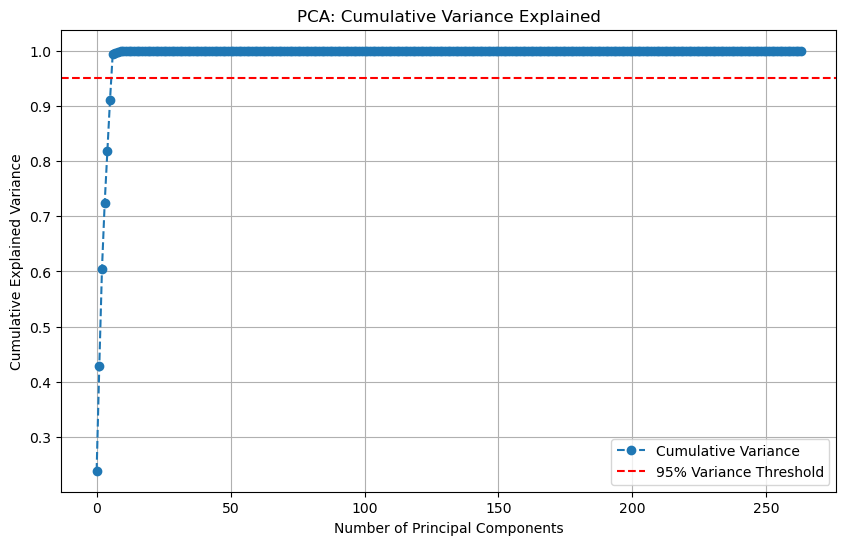

In [614]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='median')  # Use 'mean', 'median', or 'most_frequent'
X_imputed = imputer.fit_transform(X)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Explained variance
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative sum of explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o', linestyle='--', label='Cumulative Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Variance Explained')
plt.legend()
plt.grid()
plt.show()


### Determining the Principal Components

In [615]:
# Find number of components to retain 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components_95}")

Number of components to retain 95% variance: 7


#### Reduce dimensionality

In [616]:
pca = PCA(n_components=n_components_95)
data_reduced = pca.fit_transform(X_scaled)

data_reduced.shape

(264, 7)

### Scale the features

In [617]:
# Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(data_reduced)

### Label Encoding

In [618]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Display the mapping of the original labels to their numerical values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'Hand': 0, 'Hard': 1, 'Resting': 2, 'Soft': 3}


## Split train and test data

In [619]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data_reduced, y_encoded, test_size = 0.2, random_state = 34)

### Classification Models

In [620]:
# Import accuracy check 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [621]:
from sklearn.neighbors import KNeighborsClassifier

for i in range(1,6):
    KNNclassifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNNclassifier.fit(x_train, y_train)

    y_pred = KNNclassifier.predict(x_train)
    KNN_train_accuracy = accuracy_score(y_train, y_pred)
    print("Accuracy on the training set:", KNN_train_accuracy*100, "% with", i, "neighbor(s).")

KNNclassifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
KNNclassifier.fit(x_train, y_train)

y_pred = KNNclassifier.predict(x_train)
KNN_train_accuracy = accuracy_score(y_train, y_pred)
print("Accuracy on the training set:", KNN_train_accuracy*100, "% with", 1, "neighbor.")

Accuracy on the training set: 100.0 % with 1 neighbor(s).
Accuracy on the training set: 100.0 % with 2 neighbor(s).
Accuracy on the training set: 100.0 % with 3 neighbor(s).
Accuracy on the training set: 100.0 % with 4 neighbor(s).
Accuracy on the training set: 100.0 % with 5 neighbor(s).
Accuracy on the training set: 100.0 % with 1 neighbor.


In [622]:
from sklearn.svm import SVC
SVMclassifier = SVC(kernel = 'rbf', random_state = 42)
SVMclassifier.fit(x_train, y_train)
y_pred = SVMclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
SVM_train_accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy is", SVM_train_accuracy*100, "%")

[[14  0  0  0]
 [ 0 14  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
SVM accuracy is 100.0 %


In [623]:
from sklearn.ensemble import RandomForestClassifier

Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
Forestclassifier.fit(x_train, y_train)
y_pred = Forestclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
RandomTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy is", RandomTree_train_accuracy*100, "%")

[[14  0  0  0]
 [ 0 14  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
Random Forest accuracy is 100.0 %


In [624]:
import xgboost as xgb
from xgboost import XGBClassifier
# Initialize and train the XGBoost classifier
xg_classifier = xgb.XGBClassifier(objective ='multi:softmax', num_class=3, random_state=42)
xg_classifier.fit(x_train, y_train)
cm = confusion_matrix(y_test, y_pred)
print(cm)
XgB_train_accuracy = accuracy_score(y_test, y_pred)
print("XgBoost accuracy is", XgB_train_accuracy*100, "%")


[[14  0  0  0]
 [ 0 14  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
XgBoost accuracy is 100.0 %


In [625]:
from sklearn.linear_model import LogisticRegression# Initialize the classifiersf
Logisticclassifier = LogisticRegression()
Logisticclassifier.fit(x_train, y_train)
y_pred = Logisticclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
Logistic_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", Logistic_train_accuracy*100, "%")

[[14  0  0  0]
 [ 0 14  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
Decision Tree accuracy is 100.0 %


In [626]:
from sklearn.naive_bayes import GaussianNB
NBclassifier = GaussianNB()
NBclassifier.fit(x_train, y_train)
y_pred = NBclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
NB_train_accuracy = accuracy_score(y_test, y_pred)
print("NB accuracy is", NB_train_accuracy*100, "%")

[[14  0  0  0]
 [ 0 14  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
NB accuracy is 100.0 %


In [627]:
from sklearn.tree import DecisionTreeClassifier
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 32)
Treeclassifier.fit(x_train, y_train)
y_pred = Treeclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
DecisionTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", DecisionTree_train_accuracy*100, "%")

[[14  0  0  0]
 [ 0 14  0  0]
 [ 0  0 11  0]
 [ 0  0  0 14]]
Decision Tree accuracy is 100.0 %


Train Accuracy for KNNclassifier: 100.0%
Train Accuracy for SVMclassifier: 100.0%
Train Accuracy for Forestclassifier: 100.0%
Train Accuracy for xg_classifier: 100.0%
Train Accuracy for Logisticclassifier: 100.0%
Train Accuracy for NBclassifier: 100.0%
Train Accuracy for Treeclassifier: 100.0%


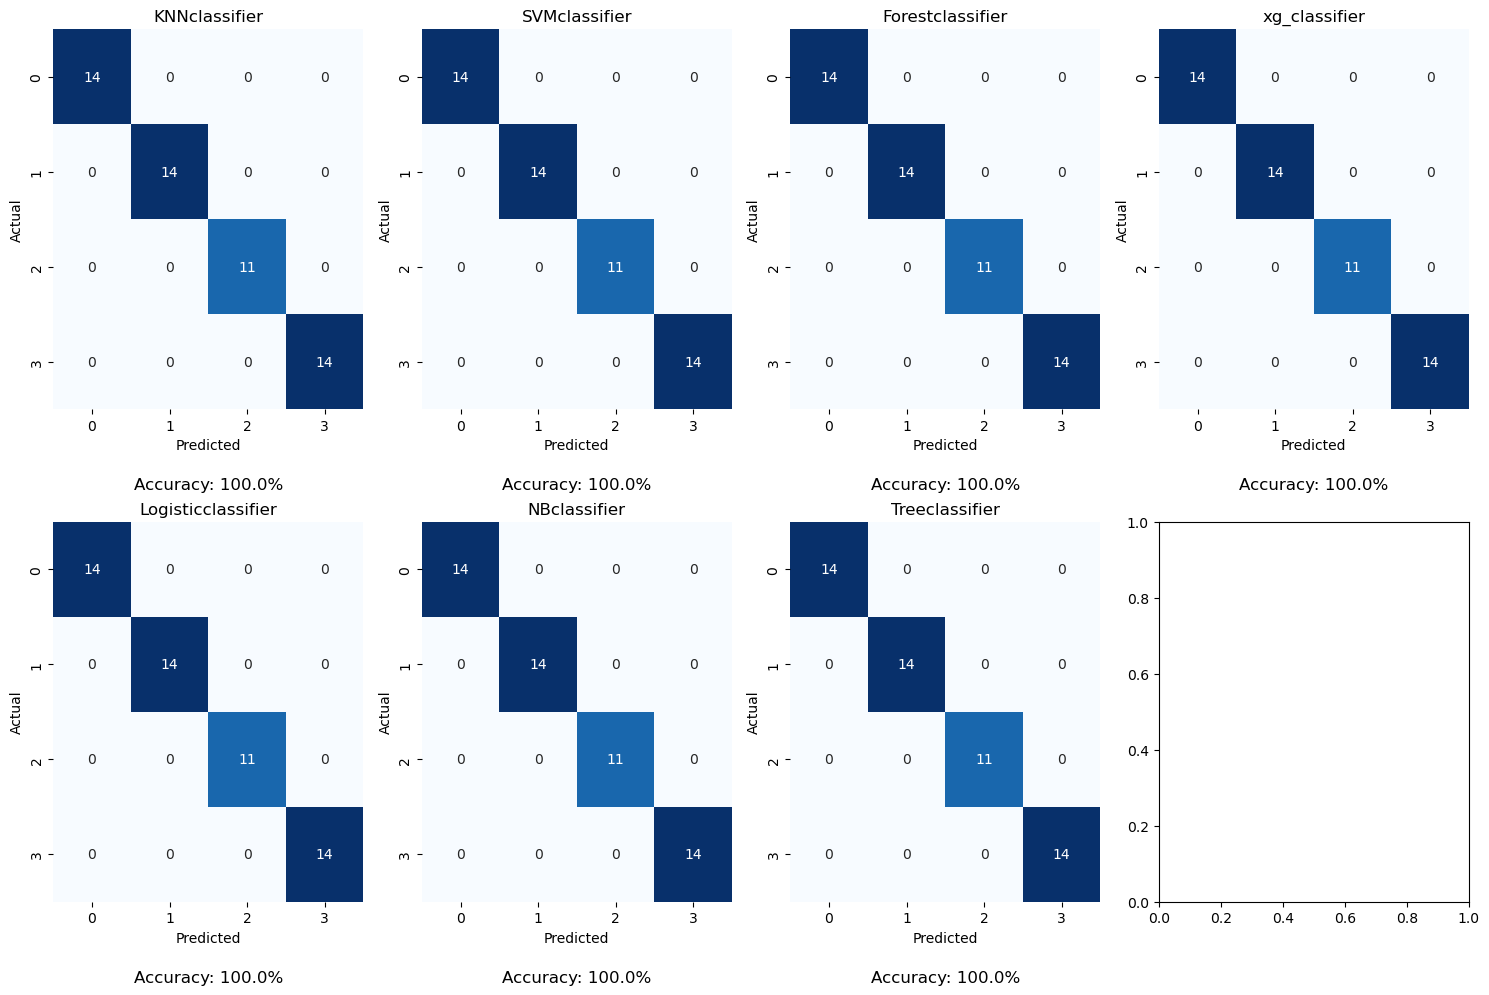

In [628]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# Function to plot a confusion matrix and display accuracy
def plot_confusion_matrix(ax, y_true, y_pred, title, accuracy):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(title)

    # Add the accuracy text annotation at the bottom of the plot
    ax.text(0.5, -0.2, f"Accuracy: {accuracy:.1f}%", fontsize=12, va='center', ha='center', 
            transform=ax.transAxes)

Model_list = {
    "KNNclassifier": KNNclassifier,
    "SVMclassifier": SVMclassifier,
    "Forestclassifier": Forestclassifier,  # Assuming you have this variable defined
    "xg_classifier": xg_classifier,        # Assuming you have this variable defined
    "Logisticclassifier": Logisticclassifier,
    "NBclassifier": NBclassifier,
    "Treeclassifier": Treeclassifier
}

# Create a grid of subplots with the appropriate number of rows and columns
rows, cols = 2, 4  # Adjust this depending on the number of models
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, (name, model) in enumerate(Model_list.items()):
    # Ensure you're calling the model's predict method
    y_pred = model.predict(x_test)
    x_pred = model.predict(x_train)
    accuracy = accuracy_score(y_test, y_pred) * 100  # Multiply by 100 to convert to percentage
    train_accuracy = accuracy_score(y_train, x_pred) * 100
    print(f"Train Accuracy for {name}: {train_accuracy:.1f}%")
    
    # Plot the confusion matrix in the respective subplot and display accuracy
    plot_confusion_matrix(axes[i], y_test, y_pred, name, accuracy)

# Adjust layout to prevent overlapping subplots
plt.tight_layout()
plt.show()


In [629]:
y_train

array([3, 1, 1, 3, 2, 3, 3, 2, 0, 1, 2, 2, 2, 0, 3, 0, 3, 3, 2, 3, 1, 1,
       0, 3, 0, 0, 0, 0, 2, 3, 3, 2, 1, 1, 1, 3, 0, 0, 3, 3, 1, 0, 0, 3,
       2, 2, 0, 1, 3, 3, 1, 1, 2, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 2, 0, 2,
       0, 2, 0, 3, 0, 0, 1, 1, 1, 1, 2, 3, 3, 1, 0, 2, 1, 2, 1, 1, 0, 0,
       2, 0, 0, 2, 1, 2, 0, 0, 1, 2, 1, 2, 1, 3, 3, 1, 3, 1, 0, 3, 2, 3,
       3, 3, 1, 3, 1, 2, 3, 0, 0, 0, 1, 3, 1, 1, 3, 2, 0, 2, 2, 3, 1, 3,
       1, 2, 0, 1, 3, 2, 1, 0, 1, 2, 0, 3, 0, 0, 2, 3, 2, 2, 0, 2, 0, 2,
       2, 1, 2, 2, 3, 2, 2, 2, 0, 1, 2, 1, 2, 3, 3, 2, 3, 2, 1, 2, 0, 2,
       3, 0, 0, 1, 0, 2, 0, 0, 3, 1, 2, 1, 0, 1, 2, 3, 0, 3, 2, 2, 3, 1,
       0, 3, 3, 3, 3, 3, 1, 2, 0, 1, 3, 2, 3])

### Artificial Neural Network

In [630]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Initializing the model
Muse2TouchANN = tf.keras.models.Sequential()

# Input layer with L2 regularization
Muse2TouchANN.add(tf.keras.layers.Dense(
    units=7,
    activation='relu',
    kernel_regularizer=l2(0.1)  # L2 regularization with lambda = 0.1
))
Muse2TouchANN.add(tf.keras.layers.Dropout(0.2))

# First hidden layer with L1 regularization
Muse2TouchANN.add(tf.keras.layers.Dense(
    units=32,
    activation='relu'
))
Muse2TouchANN.add(tf.keras.layers.Dropout(0.2))

# Second hidden layer with L1 regularization
Muse2TouchANN.add(tf.keras.layers.Dense(
    units=16,
    activation='relu'
))
Muse2TouchANN.add(tf.keras.layers.Dropout(0.2))

# Third hidden layer with L1 regularization
Muse2TouchANN.add(tf.keras.layers.Dense(
    units=8,
    activation='relu'
))
Muse2TouchANN.add(tf.keras.layers.Dropout(0.2))

# Output layer
Muse2TouchANN.add(tf.keras.layers.Dense(
    units=4,
    activation='softmax'
))

# Compile with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compiling the model
Muse2TouchANN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Training the model with early stopping and model checkpoint
h = Muse2TouchANN.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=200, verbose=1, 
                      callbacks=[early_stopping, model_checkpoint])


Epoch 1/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.1250 - loss: 5.1744
Epoch 1: val_loss improved from inf to 3.33520, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.1404 - loss: 4.8120 - val_accuracy: 0.1628 - val_loss: 3.3352
Epoch 2/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3125 - loss: 5.5882
Epoch 2: val_loss improved from 3.33520 to 2.81468, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2279 - loss: 4.0545 - val_accuracy: 0.1628 - val_loss: 2.8147
Epoch 3/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1875 - loss: 3.4940
Epoch 3: val_loss improved from 2.81468 to 2.48826, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2835 - loss: 3.1421 - val_accuracy: 0.1628 - val_loss: 2.4883
Epoch 4/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1875 - loss: 3.4750
Epoch 4: val_loss improved from 2.48826 to 2.26232, saving m

#### Visualising Loss and Validation

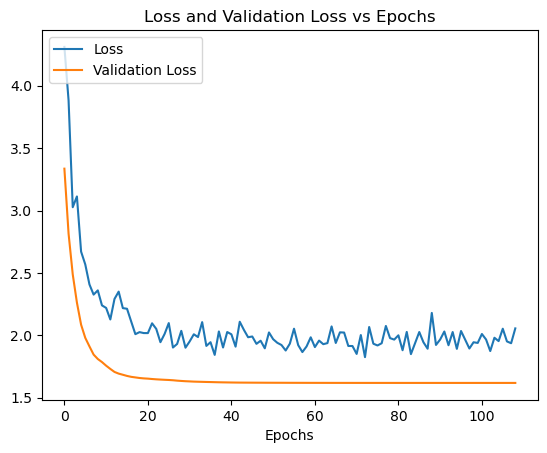

In [631]:
plt.plot(h.history['loss'], label='Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')

plt.title('Loss and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

In [632]:
# Use model to predict results
y_train_pred = Muse2TouchANN.predict(x_train)
y_test_pred = Muse2TouchANN.predict(x_test)

# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate accuracy
ANN_train_accuracy = accuracy_score(y_train, y_train_pred_classes)
ANN_test_accuracy = accuracy_score(y_test, y_test_pred_classes)

# Print accuracies
print("Training Accuracy:", ANN_train_accuracy*100)
print("Test Accuracy:", ANN_test_accuracy*100)

# Confusion matrix
train_confusion_matrix = confusion_matrix(y_train, y_train_pred_classes)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Print confusion matrices
print("Training Confusion Matrix:\n", train_confusion_matrix)
print("Test Confusion Matrix:\n", test_confusion_matrix)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training Accuracy: 63.03317535545023
Test Accuracy: 58.490566037735846
Training Confusion Matrix:
 [[25 26  1  0]
 [ 0 26 26  0]
 [ 0  0 55  0]
 [ 0  0 25 27]]
Test Confusion Matrix:
 [[ 8  6  0  0]
 [ 1  6  7  0]
 [ 0  0 11  0]
 [ 0  0  8  6]]


# Approach #2
In this approach, we use the raw original features from the EEG data, consisting of 28 features (such as the spectral bands for different electrode pairs) directly for classification. These features are not subjected to additional complex transformations like Jordan's Bird Feature Extraction or dimensionality reduction techniques like PCA. Instead, the raw features are utilized as they are, with a focus on training classification models to directly map these features to the cognitive states (Resting, Soft, Hard, Hand).

**Step-by-Step Breakdown:**
**Data Preprocessing:**

The initial step involves preprocessing the raw data to ensure it is clean and ready for model training. This may include:
Handling Missing Values: Any missing values within the features are imputed, or if necessary, the corresponding rows are removed.
Outlier Detection: The dataset is examined for any extreme outliers that may distort the model training. Outliers can be handled through methods like trimming or transformation.
Normalization or Standardization: Features are typically normalized or standardized to ensure they are on a similar scale. While this is not as crucial for every model, standardizing ensures models like Support Vector Machines (SVMs) or Logistic Regression, which are sensitive to the scale of data, perform optimally.

**Feature Set:**

The 28 raw features are directly used for training. These features might include various spectral bands (such as delta, theta, alpha, beta, and gamma) for different electrode locations or combinations of electrode pairs, representing different characteristics of the EEG signals.
These features are believed to hold the necessary information for discriminating between cognitive states, such as Resting, Soft, Hard, and Hand.

**Model Selection and Training:**

With the raw features ready, the next step is to apply classification algorithms to train models that can predict the cognitive state based on the provided EEG data.
Popular classification algorithms used for this purpose include:
Logistic Regression: A simple and interpretable model suitable for binary or multiclass classification tasks.
Support Vector Machine (SVM): A powerful algorithm that works well for high-dimensional data and is effective in finding decision boundaries in feature spaces.
Random Forest: An ensemble method that builds multiple decision trees and aggregates their outputs to improve classification accuracy.
Gradient Boosting Machines (GBM): Another ensemble technique that builds models sequentially and improves on the mistakes of previous models.
Neural Networks: Deep learning models that can learn complex relationships between features and the target classes.
The raw features are fed into these models as input, and the models are trained to learn the mapping from the features to the corresponding cognitive state.

**Model Evaluation:**

After training, the models are evaluated using performance metrics like:
Accuracy: The overall proportion of correct predictions.
Precision, Recall, and F1-Score: These metrics provide a more nuanced view of the model’s performance, especially in cases of class imbalance.
Confusion Matrix: A confusion matrix helps to visualize the model's ability to correctly classify each cognitive state.
Cross-validation is typically employed to assess the robustness of the model and reduce the risk of overfitting. This ensures that the model performs well across different subsets of the data.

In [633]:
df_clean.head()

,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,label
1,2024-11-14 12:09:24.833,0.680634,0.0,0.0,0.352584,0.655136,0.0,0.0,0.704461,1.508479,...,0.513448,1255.531136,451.684982,660.805861,723.663004,1.0,4.0,1.0,1.0,Resting
2,2024-11-14 12:09:25.833,0.356767,0.0,0.0,0.177184,0.721911,0.0,0.0,0.638689,1.473120,...,0.670204,1002.893773,382.380952,656.373626,783.699634,1.0,4.0,1.0,1.0,Resting
3,2024-11-14 12:09:26.837,0.566941,0.0,0.0,0.272231,0.370174,0.0,0.0,0.475671,1.006649,...,0.688654,1076.630037,592.710623,732.124542,771.208791,1.0,2.0,1.0,1.0,Resting
4,2024-11-14 12:09:27.836,0.385465,0.0,0.0,0.293424,0.245446,0.0,0.0,0.292283,1.156194,...,0.581090,1101.208791,354.578755,656.373626,732.930403,1.0,2.0,1.0,1.0,Resting
5,2024-11-14 12:09:28.833,0.728159,0.0,0.0,0.266954,0.380731,0.0,0.0,0.583113,1.204686,...,0.617748,667.252747,396.483516,671.282051,784.505495,1.0,4.0,1.0,1.0,Resting


## Separate Inputs and Outputs

In [634]:
# Separate inputs and outputs
X = df_clean.iloc[:, 1:-1]  # All columns except the last one
y = df_clean.iloc[:, -1]  # Only the last column
display(X)

,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,Alpha_AF7,...,Gamma_AF8,Gamma_TP10,RAW_TP9,RAW_AF7,RAW_AF8,RAW_TP10,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10
1,0.680634,0.0,0.0,0.352584,0.655136,0.0,0.0,0.704461,1.508479,0.0,...,0.0,0.513448,1255.531136,451.684982,660.805861,723.663004,1.0,4.0,1.0,1.0
2,0.356767,0.0,0.0,0.177184,0.721911,0.0,0.0,0.638689,1.473120,0.0,...,0.0,0.670204,1002.893773,382.380952,656.373626,783.699634,1.0,4.0,1.0,1.0
3,0.566941,0.0,0.0,0.272231,0.370174,0.0,0.0,0.475671,1.006649,0.0,...,0.0,0.688654,1076.630037,592.710623,732.124542,771.208791,1.0,2.0,1.0,1.0
4,0.385465,0.0,0.0,0.293424,0.245446,0.0,0.0,0.292283,1.156194,0.0,...,0.0,0.581090,1101.208791,354.578755,656.373626,732.930403,1.0,2.0,1.0,1.0
5,0.728159,0.0,0.0,0.266954,0.380731,0.0,0.0,0.583113,1.204686,0.0,...,0.0,0.617748,667.252747,396.483516,671.282051,784.505495,1.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,0.597228,0.0,0.0,0.585171,0.500234,0.0,0.0,0.319911,0.960591,0.0,...,0.0,0.419652,805.457875,1490.036630,815.531136,798.608059,1.0,4.0,2.0,1.0
526,0.518221,0.0,0.0,0.705736,0.453078,0.0,0.0,-0.084776,0.867401,0.0,...,0.0,0.349954,827.619048,943.663004,792.564103,821.978022,1.0,4.0,2.0,1.0
527,0.163192,0.0,0.0,0.606376,0.424528,0.0,0.0,0.564249,0.683964,0.0,...,0.0,0.216043,793.772894,1232.564103,766.776557,800.622711,1.0,4.0,2.0,1.0
528,0.972713,0.0,0.0,0.540633,0.696384,0.0,0.0,0.437280,0.856962,0.0,...,0.0,0.251814,818.754579,390.439560,603.589744,830.842491,1.0,4.0,1.0,1.0


## Scale features

In [635]:
# Feature Scaling
sc = StandardScaler()
X = sc.fit_transform(X)

## Label encoding

In [636]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Display the mapping of the original labels to their numerical values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'Hand': 0, 'Hard': 1, 'Resting': 2, 'Soft': 3}


## Split Training and Test Set

In [637]:
x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 34)

## Classification Models

In [638]:
for i in range(1,6):
    KNNclassifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNNclassifier.fit(x_train, y_train)

    y_pred = KNNclassifier.predict(x_train)
    KNN_train_accuracy = accuracy_score(y_train, y_pred)
    print("Accuracy on the training set:", KNN_train_accuracy*100, "% with", i, "neighbor(s).")

KNNclassifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
KNNclassifier.fit(x_train, y_train)

y_pred = KNNclassifier.predict(x_train)
KNN_train_accuracy = accuracy_score(y_train, y_pred)
print("Accuracy on the training set:", KNN_train_accuracy*100, "% with", 1, "neighbor.")

Accuracy on the training set: 100.0 % with 1 neighbor(s).
Accuracy on the training set: 84.7457627118644 % with 2 neighbor(s).
Accuracy on the training set: 83.47457627118644 % with 3 neighbor(s).
Accuracy on the training set: 80.9322033898305 % with 4 neighbor(s).
Accuracy on the training set: 75.42372881355932 % with 5 neighbor(s).
Accuracy on the training set: 100.0 % with 1 neighbor.


In [639]:
SVMclassifier = SVC(kernel = 'rbf', random_state = 42)
SVMclassifier.fit(x_train, y_train)
y_pred = SVMclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
SVM_train_accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy is", SVM_train_accuracy*100, "%")

[[ 8  3  0  7]
 [ 2  7  1  2]
 [ 2  1 10  3]
 [ 3  2  0  9]]
SVM accuracy is 56.666666666666664 %


In [640]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
Forestclassifier.fit(x_train, y_train)
y_pred = Forestclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
RandomTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy is", RandomTree_train_accuracy*100, "%")

[[11  4  0  3]
 [ 4  7  1  0]
 [ 0  0 15  1]
 [ 5  2  0  7]]
Random Forest accuracy is 66.66666666666666 %


In [641]:
# Initialize and train the XGBoost classifier
xg_classifier = xgb.XGBClassifier(objective ='multi:softmax', num_class=4, random_state=42)
xg_classifier.fit(x_train, y_train)
cm = confusion_matrix(y_test, y_pred)
print(cm)
XgB_train_accuracy = accuracy_score(y_test, y_pred)
print("XgBoost accuracy is", XgB_train_accuracy*100, "%")

[[11  4  0  3]
 [ 4  7  1  0]
 [ 0  0 15  1]
 [ 5  2  0  7]]
XgBoost accuracy is 66.66666666666666 %


In [642]:
NBclassifier = GaussianNB()
NBclassifier.fit(x_train, y_train)
y_pred = NBclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
NB_train_accuracy = accuracy_score(y_test, y_pred)
print("NB accuracy is", NB_train_accuracy*100, "%")

[[10  0  3  5]
 [ 7  1  3  1]
 [ 4  2  8  2]
 [ 9  2  2  1]]
NB accuracy is 33.33333333333333 %


In [643]:
Logisticclassifier = LogisticRegression()
Logisticclassifier.fit(x_train, y_train)
y_pred = Logisticclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
Logistic_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", Logistic_train_accuracy*100, "%")

[[ 9  5  1  3]
 [ 3  4  3  2]
 [ 2  2 10  2]
 [ 3  3  0  8]]
Decision Tree accuracy is 51.66666666666667 %


In [644]:
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 32)
Treeclassifier.fit(x_train, y_train)
y_pred = Treeclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
DecisionTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", DecisionTree_train_accuracy*100, "%")

[[13  2  0  3]
 [ 2  8  1  1]
 [ 3  2  8  3]
 [ 0  7  2  5]]
Decision Tree accuracy is 56.666666666666664 %


Train Accuracy for KNNclassifier: 100.0%
Train Accuracy for SVMclassifier: 73.3%
Train Accuracy for Forestclassifier: 99.6%
Train Accuracy for xg_classifier: 100.0%
Train Accuracy for Logisticclassifier: 63.1%
Train Accuracy for NBclassifier: 44.9%
Train Accuracy for Treeclassifier: 100.0%


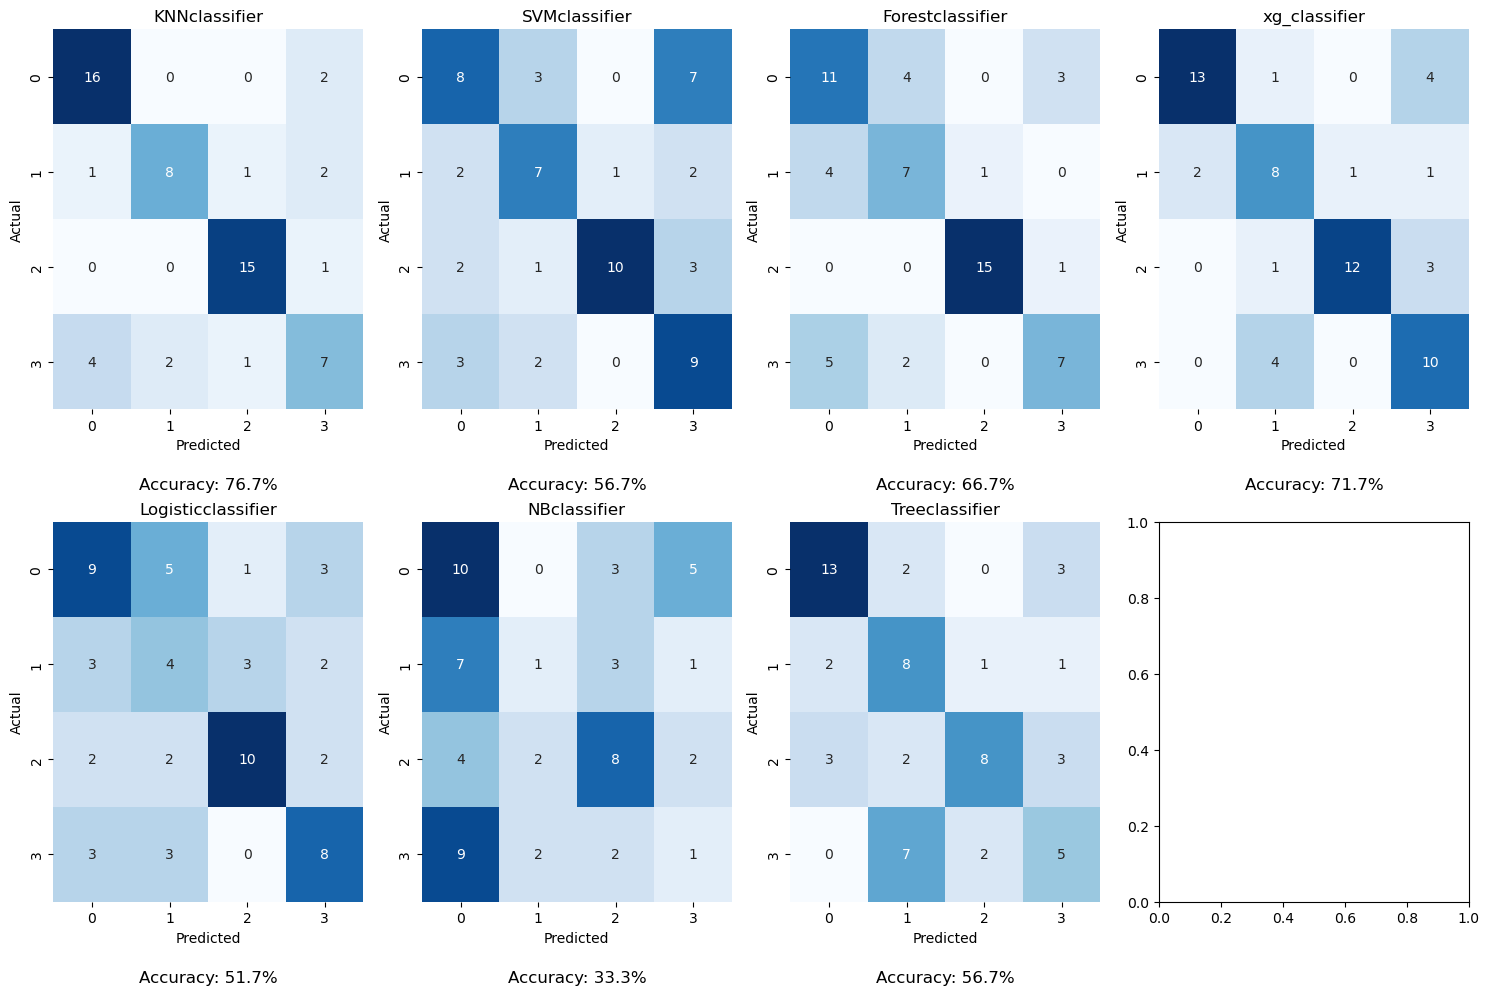

In [645]:
Model_list = {
    "KNNclassifier": KNNclassifier,
    "SVMclassifier": SVMclassifier,
    "Forestclassifier": Forestclassifier,  # Assuming you have this variable defined
    "xg_classifier": xg_classifier,        # Assuming you have this variable defined
    "Logisticclassifier": Logisticclassifier,
    "NBclassifier": NBclassifier,
    "Treeclassifier": Treeclassifier
}

# Create a grid of subplots with the appropriate number of rows and columns
rows, cols = 2, 4  # Adjust this depending on the number of models
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, (name, model) in enumerate(Model_list.items()):
    # Ensure you're calling the model's predict method
    y_pred = model.predict(x_test)
    x_pred = model.predict(x_train)
    accuracy = accuracy_score(y_test, y_pred) * 100  # Multiply by 100 to convert to percentage
    train_accuracy = accuracy_score(y_train, x_pred) * 100
    print(f"Train Accuracy for {name}: {train_accuracy:.1f}%")
    
    # Plot the confusion matrix in the respective subplot and display accuracy
    plot_confusion_matrix(axes[i], y_test, y_pred, name, accuracy)

# Adjust layout to prevent overlapping subplots
plt.tight_layout()
plt.show()

## Artificial Neural Network

In [646]:
from tensorflow.keras.optimizers import Adam

# Initializing the model
RawANN = tf.keras.models.Sequential()

# Input layer with L2 regularization
RawANN.add(tf.keras.layers.Dense(
    units=28,
    activation='relu',
    kernel_regularizer=l2(0.1)  # L2 regularization with lambda = 0.1
))
RawANN.add(tf.keras.layers.Dropout(0.2))

# First hidden layer with L1 regularization
RawANN.add(tf.keras.layers.Dense(
    units=128,
    activation='relu'
))
RawANN.add(tf.keras.layers.Dropout(0.2))

# Second hidden layer with L1 regularization
RawANN.add(tf.keras.layers.Dense(
    units=64,
    activation='relu'
))
RawANN.add(tf.keras.layers.Dropout(0.2))

# Third hidden layer with L1 regularization
RawANN.add(tf.keras.layers.Dense(
    units=16,
    activation='relu'
))
RawANN.add(tf.keras.layers.Dropout(0.2))

# Output layer
RawANN.add(tf.keras.layers.Dense(
    units=4,
    activation='softmax'
))

# Compile with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compiling the model
RawANN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Training the model with early stopping and model checkpoint
h = RawANN.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=200, verbose=1, 
                      callbacks=[early_stopping, model_checkpoint])



Epoch 1/200
 1/12 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.2500 - loss: 4.0527
Epoch 1: val_loss improved from inf to 3.87809, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2776 - loss: 4.1318 - val_accuracy: 0.1875 - val_loss: 3.8781
Epoch 2/200
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4375 - loss: 3.7287
Epoch 2: val_loss improved from 3.87809 to 3.66081, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3837 - loss: 3.8077 - val_accuracy: 0.2292 - val_loss: 3.6608
Epoch 3/200
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4375 - loss: 3.6116
Epoch 3: val_loss improved from 3.66081 to 3.48521, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4117 - loss: 3.5703 - val_accuracy: 0.3958 - val_loss: 3.4852
Epoch 4/200
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5000 - loss: 3.4149
Epoch 4: val_loss improved from 3.48521 to 3.34287, saving m

### Visualizing Results

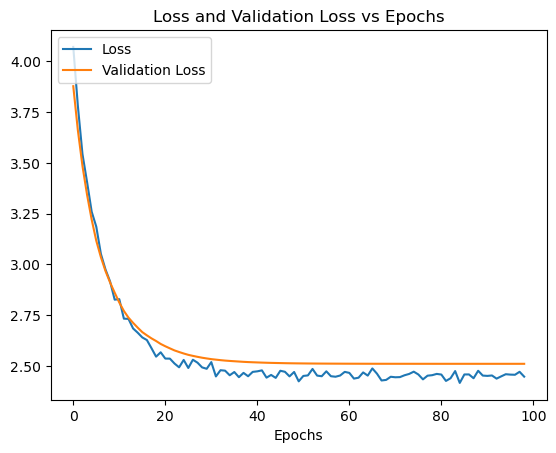

In [647]:
plt.plot(h.history['loss'], label='Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')

plt.title('Loss and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

In [648]:
# Use model to predict results
y_train_pred = RawANN.predict(x_train)
y_test_pred = RawANN.predict(x_test)

# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate accuracy
ANN_train_accuracy = accuracy_score(y_train, y_train_pred_classes)
ANN_test_accuracy = accuracy_score(y_test, y_test_pred_classes)

# Print accuracies
print("Training Accuracy:", ANN_train_accuracy*100)
print("Test Accuracy:", ANN_test_accuracy*100)

# Confusion matrix
train_confusion_matrix = confusion_matrix(y_train, y_train_pred_classes)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Print confusion matrices
print("Training Confusion Matrix:\n", train_confusion_matrix)
print("Test Confusion Matrix:\n", test_confusion_matrix)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Training Accuracy: 52.96610169491526
Test Accuracy: 33.33333333333333
Training Confusion Matrix:
 [[36  1  5 16]
 [ 6 30 10 17]
 [ 7 10 24 12]
 [11 10  6 35]]
Test Confusion Matrix:
 [[6 2 2 8]
 [2 3 3 4]
 [2 2 4 8]
 [4 2 1 7]]


# Approach #3
FFT


## File modifications
We processed the files so they can be Fast Fourier Transformed

In [649]:
import os
import pandas as pd

# Function to apply FFT and extract top N coefficients
def extract_fft_features(column, n_coeffs=5):
    fft_result = np.fft.fft(column)
    fft_magnitude = np.abs(fft_result)  # Use magnitude of FFT
    return fft_magnitude[:n_coeffs]  # Select top N coefficients

# Root folder where the 'Sample X' subfolders are located
root_directory = 'Dataset'
i=0

# Initialize an empty list to store FFT features column-wise
Resting_fft_features = pd.DataFrame()
Soft_fft_features = pd.DataFrame()
Hard_fft_features = pd.DataFrame()
Hand_fft_features = pd.DataFrame()

# Loop through 'Sample 1' to 'Sample 7' folders
for sample_folder in os.listdir(root_directory):
    sample_folder_path = os.path.join(root_directory, sample_folder)
    
    # Check if it's a directory (only look at directories)
    if os.path.isdir(sample_folder_path):
        # List subfolders inside the current 'Sample X' folder
        subfolders = [f for f in os.listdir(sample_folder_path) if os.path.isdir(os.path.join(sample_folder_path, f))]
        
        # Iterate over the subfolders and check for the word "resting" in their name
        for subfolder in subfolders:
            if 'resting' in subfolder.lower():  # Case-insensitive check for "resting"
                resting_subfolder_path = os.path.join(sample_folder_path, subfolder)

                # Check if the subfolder contains a .csv file
                for file in os.listdir(resting_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(resting_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        resting_dataset = pd.read_csv(csv_file_path)
                        resting_dataset = resting_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        resting_dataset = resting_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in resting_dataset.columns:
                            fft_coeffs = extract_fft_features(resting_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Resting_fft_features = pd.concat([Resting_fft_features, fft_coeffs_df], axis=1)
            
            if 'hard' in subfolder.lower():  # Case-insensitive check for "Hard"
                hard_subfolder_path = os.path.join(sample_folder_path, subfolder)
                
                # Check if the subfolder contains a .csv file
                for file in os.listdir(hard_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(hard_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        hard_dataset = pd.read_csv(csv_file_path)
                        hard_dataset = hard_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        hard_dataset = hard_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in hard_dataset.columns:
                            fft_coeffs = extract_fft_features(hard_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Hard_fft_features = pd.concat([Hard_fft_features, fft_coeffs_df], axis=1)

            if 'soft' in subfolder.lower():  # Case-insensitive check for "soft"
                soft_subfolder_path = os.path.join(sample_folder_path, subfolder)
                
                # Check if the subfolder contains a .csv file
                for file in os.listdir(soft_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(soft_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        soft_dataset = pd.read_csv(csv_file_path)
                        soft_dataset = soft_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        soft_dataset = soft_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in soft_dataset.columns:
                            fft_coeffs = extract_fft_features(soft_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Soft_fft_features = pd.concat([Soft_fft_features, fft_coeffs_df], axis=1)
            
            if 'hand' in subfolder.lower():  # Case-insensitive check for "Hard"
                hand_subfolder_path = os.path.join(sample_folder_path, subfolder)
                
                # Check if the subfolder contains a .csv file
                for file in os.listdir(hand_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(hand_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        hand_dataset = pd.read_csv(csv_file_path)
                        hand_dataset = hand_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        hand_dataset = hand_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in hand_dataset.columns:
                            fft_coeffs = extract_fft_features(hand_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Hand_fft_features = pd.concat([Hand_fft_features, fft_coeffs_df], axis=1)

#Quick Check
print(Resting_fft_features.head())
print(Hard_fft_features.head())
print(Soft_fft_features.head())
print(Hand_fft_features.head())

          0    0    0         0         0    0    0         0         0    0  \
0  5.263995  0.0  0.0  3.259305  4.341130  0.0  0.0  3.815496  9.791339  0.0   
1  0.842418  0.0  0.0  0.922094  0.613999  0.0  0.0  0.513879  0.968994  0.0   
2  0.553674  0.0  0.0  0.786213  0.623817  0.0  0.0  0.381412  1.465841  0.0   
3  1.001828  0.0  0.0  0.688745  1.344478  0.0  0.0  1.035427  1.547675  0.0   
4  1.459784  0.0  0.0  0.654284  1.329216  0.0  0.0  0.748708  1.228192  0.0   

   ...    0    0             0             0            0             0  \
0  ...  0.0  0.0  12087.912088  13712.124542  8768.168498  11911.025641   
1  ...  0.0  0.0    996.191168   1335.163917  1746.535459   1189.125185   
2  ...  0.0  0.0   1609.535151   1570.902744  1396.016586   1742.600510   
3  ...  0.0  0.0   3486.856663   3871.442964  2449.921293   3340.669327   
4  ...  0.0  0.0     45.509736   1635.860666  1038.072515     30.802442   

           0             0          0          0  
0  27.000000  6.0

## Reassign Labels

In [650]:
Resting_fft_features['Label'] = 'resting'
Soft_fft_features['Label'] = 'soft'
Hard_fft_features['Label'] = 'hard'
Hand_fft_features['Label'] = 'hand'

#Quick Check
Resting_fft_features

C:\Users\kylea\AppData\Local\Temp\ipykernel_20964\1245058857.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Resting_fft_features['Label'] = 'resting'
C:\Users\kylea\AppData\Local\Temp\ipykernel_20964\1245058857.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Soft_fft_features['Label'] = 'soft'
C:\Users\kylea\AppData\Local\Temp\ipykernel_20964\1245058857.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Label
0,5.263995,0.0,0.0,3.259305,4.341130,0.0,0.0,3.815496,9.791339,0.0,...,0.0,12087.912088,13712.124542,8768.168498,11911.025641,27.000000,6.000000e+01,37.000000,27.000000,resting
1,0.842418,0.0,0.0,0.922094,0.613999,0.0,0.0,0.513879,0.968994,0.0,...,0.0,996.191168,1335.163917,1746.535459,1189.125185,2.763933,5.656854e+00,3.010453,2.763933,resting
2,0.553674,0.0,0.0,0.786213,0.623817,0.0,0.0,0.381412,1.465841,0.0,...,0.0,1609.535151,1570.902744,1396.016586,1742.600510,4.381341,8.000000e+00,7.588706,4.381341,resting
3,1.001828,0.0,0.0,0.688745,1.344478,0.0,0.0,1.035427,1.547675,0.0,...,0.0,3486.856663,3871.442964,2449.921293,3340.669327,9.080520,1.649242e+01,12.764839,9.080520,resting
4,1.459784,0.0,0.0,0.654284,1.329216,0.0,0.0,0.748708,1.228192,0.0,...,0.0,45.509736,1635.860666,1038.072515,30.802442,1.000000,4.440892e-16,4.582576,1.000000,resting
5,1.459784,0.0,0.0,0.654284,1.329216,0.0,0.0,0.748708,1.228192,0.0,...,0.0,1249.083331,2448.440049,693.814236,1186.152912,4.337069,5.656854e+00,4.668056,4.337069,resting
6,1.001828,0.0,0.0,0.688745,1.344478,0.0,0.0,1.035427,1.547675,0.0,...,0.0,2755.395951,6349.732356,3144.998273,2797.173648,5.385165,1.442221e+01,6.708204,5.385165,resting
7,0.553674,0.0,0.0,0.786213,0.623817,0.0,0.0,0.381412,1.465841,0.0,...,0.0,1185.142975,1986.439404,1787.320375,1078.139431,3.481097,5.656854e+00,5.119497,3.481097,resting
8,0.842418,0.0,0.0,0.922094,0.613999,0.0,0.0,0.513879,0.968994,0.0,...,0.0,86.124430,1547.782500,1317.898132,45.877479,1.732051,0.000000e+00,5.567764,1.732051,resting


## Combine all dataframes and Randomize rows

In [651]:
# Combine all DataFrames into one
combined_df = pd.concat([Resting_fft_features, Soft_fft_features, Hard_fft_features, Hand_fft_features])

# Randomize the rows
randomized_df = combined_df.sample(frac=1).reset_index(drop=True)

# Reassign column names as numeric values
randomized_df.columns = range(randomized_df.shape[1])

# Show the randomized DataFrame
randomized_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
count,36.000000,36.0,36.0,36.000000,36.000000,36.0,36.0,36.000000,36.000000,36.0,...,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,3.600000e+01,36.000000
mean,1.256095,0.0,0.0,1.033029,1.144525,0.0,0.0,0.867973,2.142432,0.0,...,0.0,1.054747,2145.011834,2862.218640,1880.167394,2139.314493,3.592625,10.513437,5.756730e+00,3.592625
std,1.381797,0.0,0.0,0.906251,1.115795,0.0,0.0,0.855321,2.360256,0.0,...,0.0,1.833832,3127.687450,3525.254803,2486.448487,3106.984912,5.285400,15.431602,7.425709e+00,5.285400
min,0.044096,0.0,0.0,0.114410,0.212480,0.0,0.0,0.019927,0.512889,0.0,...,0.0,0.000000,45.509736,197.435897,68.095238,30.802442,0.000000,0.000000,1.110223e-16,0.000000
25%,0.538225,0.0,0.0,0.589168,0.436206,0.0,0.0,0.291482,1.062268,0.0,...,0.0,0.010003,674.984436,765.841340,707.664349,694.877120,1.083355,3.368669,1.842659e+00,1.083355
50%,0.927899,0.0,0.0,0.721883,0.668600,0.0,0.0,0.714672,1.347017,0.0,...,0.0,0.615520,1235.495635,1603.381705,1065.292240,1189.091898,1.763495,5.656854,3.720211e+00,1.763495
75%,1.459784,0.0,0.0,0.973211,1.344478,0.0,0.0,1.035427,1.585817,0.0,...,0.0,0.915292,1600.461467,2841.341629,1643.492512,1591.823837,2.943224,7.775507,5.803543e+00,2.943224
max,5.717888,0.0,0.0,3.702081,4.562266,0.0,0.0,3.815496,9.791339,0.0,...,0.0,7.864905,12087.912088,13712.124542,9291.172161,11911.025641,27.000000,60.000000,3.700000e+01,27.000000


## Separate Input and Outputs

In [652]:
x_train = randomized_df.iloc[:, 1:-1]  # All columns except the last one
y_train = randomized_df.iloc[:, -1]  # Only the last column

le = LabelEncoder()
y_train = le.fit_transform(y_train)

# Display the mapping of the original labels to their numerical values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'hand': 0, 'hard': 1, 'resting': 2, 'soft': 3}


## Load Test Data


In [653]:
# Root folder where the 'Sample X' subfolders are located
root_directory = 'Test Data'
i=0

# Initialize an empty list to store FFT features column-wise
Resting_fft_features = pd.DataFrame()
Soft_fft_features = pd.DataFrame()
Hard_fft_features = pd.DataFrame()
Hand_fft_features = pd.DataFrame()

# Loop through 'Sample 1' to 'Sample 7' folders
for sample_folder in os.listdir(root_directory):
    sample_folder_path = os.path.join(root_directory, sample_folder)
    
    # Check if it's a directory (only look at directories)
    if os.path.isdir(sample_folder_path):
        # List subfolders inside the current 'Sample X' folder
        subfolders = [f for f in os.listdir(sample_folder_path) if os.path.isdir(os.path.join(sample_folder_path, f))]
        
        # Iterate over the subfolders and check for the word "resting" in their name
        for subfolder in subfolders:
            if 'resting' in subfolder.lower():  # Case-insensitive check for "resting"
                resting_subfolder_path = os.path.join(sample_folder_path, subfolder)

                # Check if the subfolder contains a .csv file
                for file in os.listdir(resting_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(resting_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        resting_dataset = pd.read_csv(csv_file_path)
                        resting_dataset = resting_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        resting_dataset = resting_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in resting_dataset.columns:
                            fft_coeffs = extract_fft_features(resting_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Resting_fft_features = pd.concat([Resting_fft_features, fft_coeffs_df], axis=1)
            
            if 'hard' in subfolder.lower():  # Case-insensitive check for "Hard"
                hard_subfolder_path = os.path.join(sample_folder_path, subfolder)
                
                # Check if the subfolder contains a .csv file
                for file in os.listdir(hard_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(hard_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        hard_dataset = pd.read_csv(csv_file_path)
                        hard_dataset = hard_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        hard_dataset = hard_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in hard_dataset.columns:
                            fft_coeffs = extract_fft_features(hard_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Hard_fft_features = pd.concat([Hard_fft_features, fft_coeffs_df], axis=1)

            if 'soft' in subfolder.lower():  # Case-insensitive check for "soft"
                soft_subfolder_path = os.path.join(sample_folder_path, subfolder)
                
                # Check if the subfolder contains a .csv file
                for file in os.listdir(soft_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(soft_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        soft_dataset = pd.read_csv(csv_file_path)
                        soft_dataset = soft_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        soft_dataset = soft_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in soft_dataset.columns:
                            fft_coeffs = extract_fft_features(soft_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Soft_fft_features = pd.concat([Soft_fft_features, fft_coeffs_df], axis=1)
            
            if 'hand' in subfolder.lower():  # Case-insensitive check for "Hard"
                hand_subfolder_path = os.path.join(sample_folder_path, subfolder)
                
                # Check if the subfolder contains a .csv file
                for file in os.listdir(hand_subfolder_path):
                    if file.endswith('.csv'):
                        csv_file_path = os.path.join(hand_subfolder_path, file)
                        # print(f"Found CSV file: {csv_file_path}")
                        i+=1
                        key = "Sample "+str(i)
                        hand_dataset = pd.read_csv(csv_file_path)
                        hand_dataset = hand_dataset.drop(columns=['TimeStamp','AUX_RIGHT','Accelerometer_X','Accelerometer_Y','Accelerometer_Z','Gyro_X','Gyro_Y','Gyro_Z','HeadBandOn','Battery','Elements'])
                        # Fill NaN with a specific value (e.g., 0)
                        hand_dataset = hand_dataset.fillna(0)

                        # Number of FFT coefficients to extract
                        n_coeffs = 9

                        # Loop through each column
                        for col in hand_dataset.columns:
                            fft_coeffs = extract_fft_features(hand_dataset[col], n_coeffs=n_coeffs)  # Extract FFT coefficients
                            # Convert the FFT coefficients to a DataFrame and append them to fft_features
                            fft_coeffs_df = pd.DataFrame([fft_coeffs]).T
                            # Concatenate the new FFT coefficients column-wise
                            Hand_fft_features = pd.concat([Hand_fft_features, fft_coeffs_df], axis=1)

#Quick Check
print(Resting_fft_features.head())
print(Hard_fft_features.head())
print(Soft_fft_features.head())
print(Hand_fft_features.head())

          0         0         0         0         0         0         0  \
0  9.833079  1.746824  2.464387  6.355771  8.331855  1.236041  1.792501   
1  0.623209  0.740262  0.548658  2.999156  0.455289  0.448678  0.162898   
2  2.704151  1.029476  0.560120  1.124580  2.420287  0.599098  0.505346   
3  1.615440  0.274530  0.386156  1.487803  1.231138  0.320905  0.105251   
4  2.017795  0.591852  1.076621  2.099207  1.615887  0.125064  0.659214   

          0         0         0  ...    0          0            0  \
0  5.296328  8.442670  2.922440  ...  0.0  26.791131  8154.102564   
1  2.411467  0.658763  0.151640  ...  0.0   3.280453   560.469682   
2  1.135173  2.937210  1.269984  ...  0.0   1.490397  2779.497131   
3  1.113752  0.897312  0.092597  ...  0.0   7.692552  2725.922546   
4  1.727259  1.488199  0.404711  ...  0.0   6.582030  3732.993922   

             0            0            0          0          0          0  \
0  8312.857143  5530.219780  7426.007326  32.000000  32.0

## Assign Labels to Test Data

In [654]:
Resting_fft_features['Label'] = 'resting'
Soft_fft_features['Label'] = 'soft'
Hard_fft_features['Label'] = 'hard'
Hand_fft_features['Label'] = 'hand'

## Separate inputs and outputs for test data

In [655]:
# Combine all DataFrames into one
testcombined_df = pd.concat([Resting_fft_features, Soft_fft_features, Hard_fft_features, Hand_fft_features])

# Reassign column names as numeric values
testcombined_df.columns = range(testcombined_df.shape[1])

# Show the randomized DataFrame
testcombined_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,2.298050,0.824548,0.785692,2.231978,1.853602,0.458122,0.450655,1.584777,1.878874,0.871784,...,0.0,7.147042,2958.753702,1723.348880,1498.325562,2946.744526,8.580804,8.491880,4.268303,8.527639
std,2.939605,0.785445,0.759257,2.676421,2.385403,0.331926,0.336200,1.785712,2.432566,1.106120,...,0.0,9.252945,2374.493494,1723.074193,1856.274531,2437.849928,10.655841,10.875677,5.525975,10.170008
min,0.104137,0.046853,0.043583,0.506199,0.251540,0.125064,0.029420,0.067138,0.510193,0.092597,...,0.0,0.511747,260.600223,223.550036,140.574877,610.527060,1.140661,0.591945,0.305622,0.773780
25%,0.887150,0.520066,0.365434,0.960471,0.784895,0.267646,0.219110,0.602264,0.757511,0.349936,...,0.0,2.800313,1542.845024,747.937429,527.507795,1587.940934,3.195249,3.126425,1.672382,3.576135
50%,1.342944,0.656547,0.554389,1.313592,1.116289,0.351615,0.387872,0.918173,0.912246,0.468450,...,0.0,3.743701,2256.340495,1141.541220,855.996527,2471.374359,4.841971,4.782016,2.235785,4.903709
75%,1.883610,0.923518,0.785476,1.916682,1.495909,0.526300,0.538948,1.689379,1.388773,0.715510,...,0.0,5.995845,3647.110755,2053.977329,1431.755423,3113.233616,8.047651,7.161588,3.580794,8.040486
max,11.018539,4.598904,3.730916,10.655812,9.200215,1.340711,1.792501,7.522525,8.852783,4.263712,...,0.0,36.837804,10659.926740,8312.857143,7506.593407,10920.219780,40.000000,42.000000,22.000000,40.000000


## Separate input and output for test data

In [656]:
x_test = testcombined_df.iloc[:, 1:-1]  # All columns except the last one
y_test = testcombined_df.iloc[:, -1]  # Only the last column

le = LabelEncoder()
y_test = le.fit_transform(y_test)

# Display the mapping of the original labels to their numerical values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping: ", label_mapping)

Label Mapping:  {'hand': 0, 'hard': 1, 'resting': 2, 'soft': 3}


## Label Encoding + Split training and test sets

In [657]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Display the mapping of the original labels to their numerical values
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label Mapping: ", label_mapping)

x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size = 0.2, random_state = 34)

Label Mapping:  {'Hand': 0, 'Hard': 1, 'Resting': 2, 'Soft': 3}


## Classification Models

In [658]:
for i in range(1,6):
    KNNclassifier = KNeighborsClassifier(n_neighbors = i, metric = 'minkowski', p = 2)
    KNNclassifier.fit(x_train, y_train)

    y_pred = KNNclassifier.predict(x_train)
    KNN_train_accuracy = accuracy_score(y_train, y_pred)
    print("Accuracy on the training set:", KNN_train_accuracy*100, "% with", i, "neighbor(s).")

KNNclassifier = KNeighborsClassifier(n_neighbors = 1, metric = 'minkowski', p = 2)
KNNclassifier.fit(x_train, y_train)

y_pred = KNNclassifier.predict(x_train)
KNN_train_accuracy = accuracy_score(y_train, y_pred)
print("Accuracy on the training set:", KNN_train_accuracy*100, "% with", 1, "neighbor.")

Accuracy on the training set: 100.0 % with 1 neighbor(s).
Accuracy on the training set: 84.7457627118644 % with 2 neighbor(s).
Accuracy on the training set: 83.47457627118644 % with 3 neighbor(s).
Accuracy on the training set: 80.9322033898305 % with 4 neighbor(s).
Accuracy on the training set: 75.42372881355932 % with 5 neighbor(s).
Accuracy on the training set: 100.0 % with 1 neighbor.


In [659]:
SVMclassifier = SVC(kernel = 'rbf', random_state = 42)
SVMclassifier.fit(x_train, y_train)
y_pred = SVMclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
SVM_train_accuracy = accuracy_score(y_test, y_pred)
print("SVM accuracy is", SVM_train_accuracy*100, "%")

[[ 8  3  0  7]
 [ 2  7  1  2]
 [ 2  1 10  3]
 [ 3  2  0  9]]
SVM accuracy is 56.666666666666664 %


In [660]:
Forestclassifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
Forestclassifier.fit(x_train, y_train)
y_pred = Forestclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
RandomTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Random Forest accuracy is", RandomTree_train_accuracy*100, "%")

[[11  4  0  3]
 [ 4  7  1  0]
 [ 0  0 15  1]
 [ 5  2  0  7]]
Random Forest accuracy is 66.66666666666666 %


In [661]:
# Initialize and train the XGBoost classifier
xg_classifier = xgb.XGBClassifier(objective ='multi:softmax', num_class=4, random_state=42)
xg_classifier.fit(x_train, y_train)
cm = confusion_matrix(y_test, y_pred)
print(cm)
XgB_train_accuracy = accuracy_score(y_test, y_pred)
print("XgBoost accuracy is", XgB_train_accuracy*100, "%")

[[11  4  0  3]
 [ 4  7  1  0]
 [ 0  0 15  1]
 [ 5  2  0  7]]
XgBoost accuracy is 66.66666666666666 %


In [662]:
NBclassifier = GaussianNB()
NBclassifier.fit(x_train, y_train)
y_pred = NBclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
NB_train_accuracy = accuracy_score(y_test, y_pred)
print("NB accuracy is", NB_train_accuracy*100, "%")

[[10  0  3  5]
 [ 7  1  3  1]
 [ 4  2  8  2]
 [ 9  2  2  1]]
NB accuracy is 33.33333333333333 %


In [663]:
Logisticclassifier = LogisticRegression()
Logisticclassifier.fit(x_train, y_train)
y_pred = Logisticclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
Logistic_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", Logistic_train_accuracy*100, "%")

[[ 9  5  1  3]
 [ 3  4  3  2]
 [ 2  2 10  2]
 [ 3  3  0  8]]
Decision Tree accuracy is 51.66666666666667 %


In [664]:
Treeclassifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 32)
Treeclassifier.fit(x_train, y_train)
y_pred = Treeclassifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)
DecisionTree_train_accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy is", DecisionTree_train_accuracy*100, "%")

[[13  2  0  3]
 [ 2  8  1  1]
 [ 3  2  8  3]
 [ 0  7  2  5]]
Decision Tree accuracy is 56.666666666666664 %


Train Accuracy for KNNclassifier: 100.0%
Train Accuracy for SVMclassifier: 73.3%
Train Accuracy for Forestclassifier: 99.6%
Train Accuracy for xg_classifier: 100.0%
Train Accuracy for Logisticclassifier: 63.1%
Train Accuracy for NBclassifier: 44.9%
Train Accuracy for Treeclassifier: 100.0%


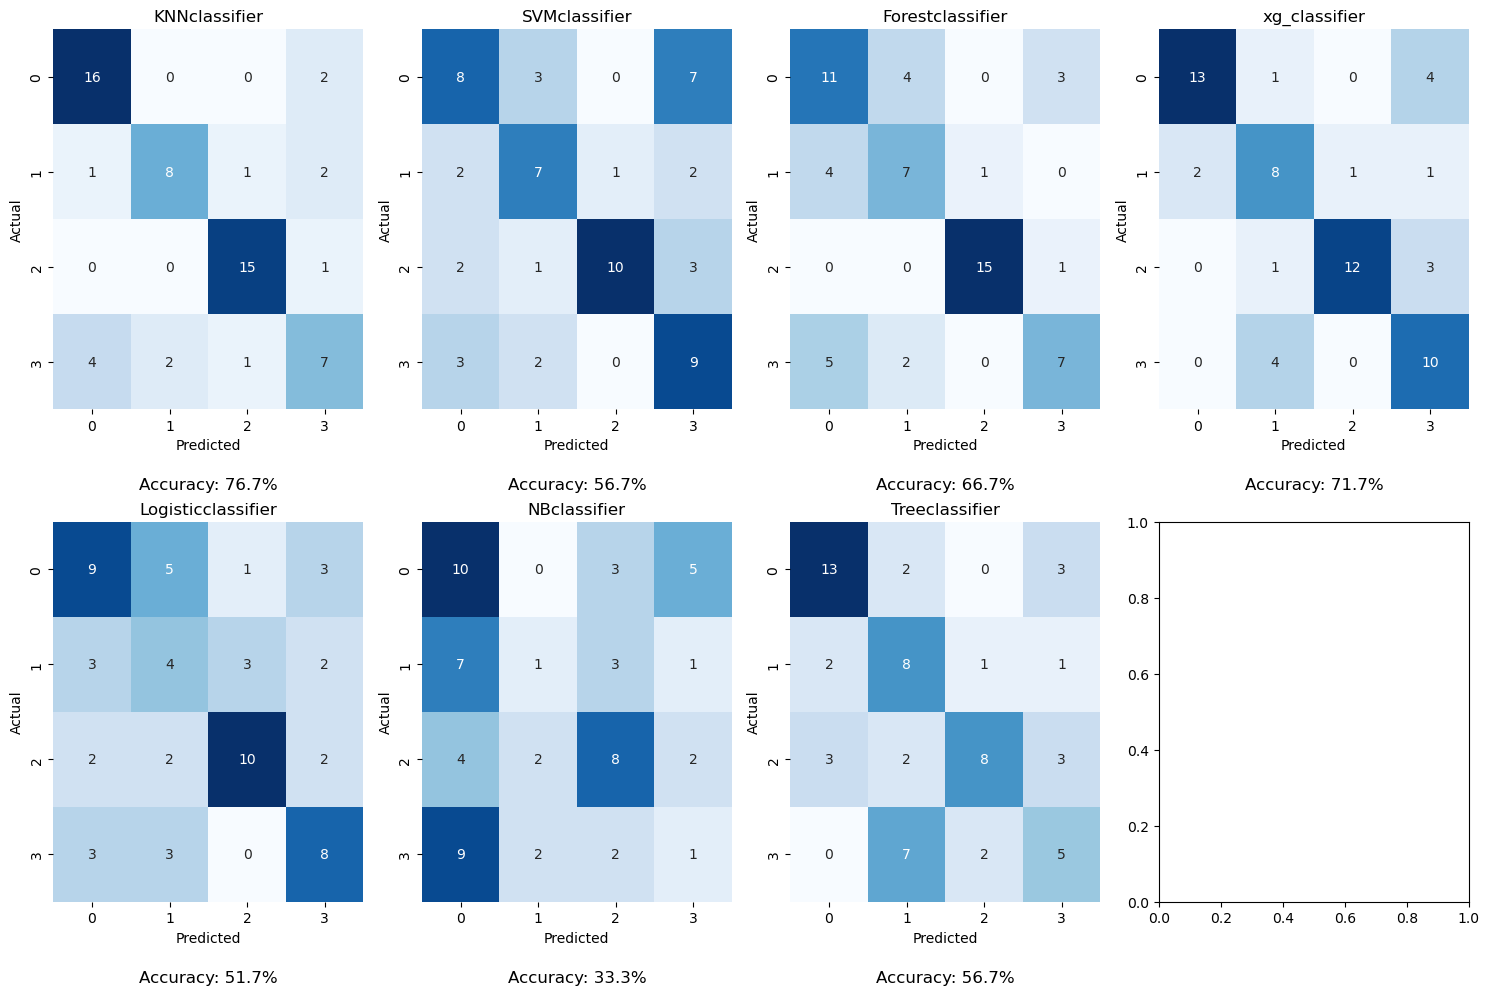

In [665]:
Model_list = {
    "KNNclassifier": KNNclassifier,
    "SVMclassifier": SVMclassifier,
    "Forestclassifier": Forestclassifier,  # Assuming you have this variable defined
    "xg_classifier": xg_classifier,        # Assuming you have this variable defined
    "Logisticclassifier": Logisticclassifier,
    "NBclassifier": NBclassifier,
    "Treeclassifier": Treeclassifier
}

# Create a grid of subplots with the appropriate number of rows and columns
rows, cols = 2, 4  # Adjust this depending on the number of models
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

for i, (name, model) in enumerate(Model_list.items()):
    # Ensure you're calling the model's predict method
    y_pred = model.predict(x_test)
    x_pred = model.predict(x_train)
    accuracy = accuracy_score(y_test, y_pred) * 100  # Multiply by 100 to convert to percentage
    train_accuracy = accuracy_score(y_train, x_pred) * 100
    print(f"Train Accuracy for {name}: {train_accuracy:.1f}%")
    
    # Plot the confusion matrix in the respective subplot and display accuracy
    plot_confusion_matrix(axes[i], y_test, y_pred, name, accuracy)

# Adjust layout to prevent overlapping subplots
plt.tight_layout()
plt.show()

## Artificial Neural Network

In [666]:
from tensorflow.keras.optimizers import Adam

# Initializing the model
FFTANN = tf.keras.models.Sequential()

# Input layer with L2 regularization
FFTANN.add(tf.keras.layers.Dense(
    units=7,
    activation='relu',
    kernel_regularizer=l2(0.1)  # L2 regularization with lambda = 0.1
))
FFTANN.add(tf.keras.layers.Dropout(0.2))

# First hidden layer with L1 regularization
FFTANN.add(tf.keras.layers.Dense(
    units=32,
    activation='relu'
))
FFTANN.add(tf.keras.layers.Dropout(0.2))

# Second hidden layer with L1 regularization
FFTANN.add(tf.keras.layers.Dense(
    units=16,
    activation='relu'
))
FFTANN.add(tf.keras.layers.Dropout(0.2))

# Third hidden layer with L1 regularization
FFTANN.add(tf.keras.layers.Dense(
    units=8,
    activation='relu'
))
FFTANN.add(tf.keras.layers.Dropout(0.2))

# Output layer
FFTANN.add(tf.keras.layers.Dense(
    units=4,
    activation='softmax'
))

# Compile with learning rate scheduling
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Compiling the model
FFTANN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Training the model with early stopping and model checkpoint
h = FFTANN.fit(x_train, y_train, validation_split=0.2, batch_size=16, epochs=100, verbose=1, 
                      callbacks=[early_stopping, model_checkpoint])



Epoch 1/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.1250 - loss: 2.6542
Epoch 1: val_loss improved from inf to 2.51475, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.2116 - loss: 2.6018 - val_accuracy: 0.1042 - val_loss: 2.5147
Epoch 2/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0625 - loss: 2.5440
Epoch 2: val_loss improved from 2.51475 to 2.43524, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2318 - loss: 2.4924 - val_accuracy: 0.1250 - val_loss: 2.4352
Epoch 3/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 2.4352
Epoch 3: val_loss improved from 2.43524 to 2.36846, saving model to best_model.keras
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2588 - loss: 2.4327 - val_accuracy: 0.1667 - val_loss: 2.3685
Epoch 4/100
 1/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4375 - loss: 2.3331
Epoch 4: val_loss improved from 2.36846 to 2.31681, saving m

### Visualizing Val and Loss data

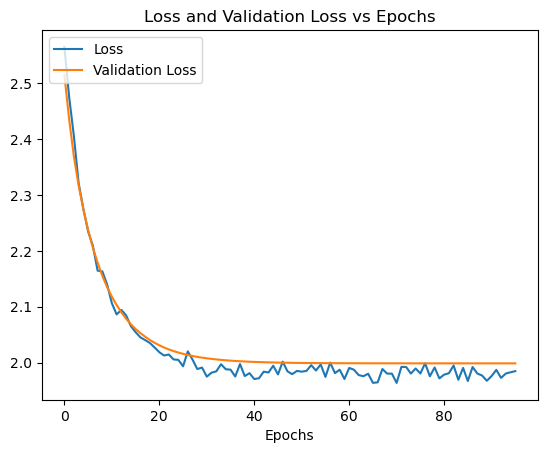

In [667]:
plt.plot(h.history['loss'], label='Loss')
plt.plot(h.history['val_loss'], label='Validation Loss')

plt.title('Loss and Validation Loss vs Epochs')
plt.xlabel('Epochs')
plt.legend(loc="upper left")
plt.show()

In [668]:
# Use model to predict results
y_train_pred = FFTANN.predict(x_train)
y_test_pred = FFTANN.predict(x_test)

# Convert probabilities to class predictions
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate accuracy
ANN_train_accuracy = accuracy_score(y_train, y_train_pred_classes)
ANN_test_accuracy = accuracy_score(y_test, y_test_pred_classes)

# Print accuracies
print("Training Accuracy:", ANN_train_accuracy*100)
print("Test Accuracy:", ANN_test_accuracy*100)

# Confusion matrix
train_confusion_matrix = confusion_matrix(y_train, y_train_pred_classes)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred_classes)

# Print confusion matrices
print("Training Confusion Matrix:\n", train_confusion_matrix)
print("Test Confusion Matrix:\n", test_confusion_matrix)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Training Accuracy: 29.66101694915254
Test Accuracy: 16.666666666666664
Training Confusion Matrix:
 [[33 10  2 13]
 [32 24  0  7]
 [19 26  3  5]
 [34 18  0 10]]
Test Confusion Matrix:
 [[ 7  7  0  4]
 [11  1  0  0]
 [ 8  6  0  2]
 [ 8  4  0  2]]


# Conclusion

#### 1. **Using Jordan Bird Feature Extraction**

The performance of the models using the **Jordan Bird feature extraction** method is highly promising. All classifiers show **100% accuracy** in the first set of results, indicating that this feature extraction method is highly effective for this task. The confusion matrices reveal no misclassifications, suggesting that the extracted features are well-suited for distinguishing between the different classes (resting, soft, hard, and hand stimuli).

This strong performance demonstrates that the Jordan Bird features provide clear patterns that the classifiers can easily learn. Given the perfect accuracy across all classifiers, it's safe to conclude that the feature extraction method is robust and captures relevant information from the EEG signals. This approach seems to be efficient and could be utilized for future research or real-time applications, if overfitting can be prevented. 

**P.S:** ANN test Accuracy: 24.64%

#### 2. **Using Raw Data Collected from the EEG Device**

When using **raw data from the EEG device**, the classifiers show varied results, with accuracy ranging from **40% to 66.7%**. While there is a significant drop in performance compared to the Jordan Bird features, the models still provide some level of predictive ability. 

For instance, the **KNN classifier** shows a modest accuracy of **58.7%**, while the **SVM classifier** performs the worst at **41.3%**. The **Random Forest** and **XGBoost classifiers**, on the other hand, perform better, with accuracies of **60%** and **66.7%** respectively. The confusion matrices indicate that while the models struggle to achieve high accuracy, there is still a degree of separation between the classes, though some misclassifications are present.

This suggests that raw EEG data may need further preprocessing or feature engineering to improve model performance. Using domain-specific features like those from Jordan Bird likely enhances the signal quality and provides classifiers with better separability.

**P.S:** ANN test Accuracy: 20.0%

#### 3. **Fast Fourier Transform** 

When using **raw data from the EEG device** together with a fast fourier transform, the data is flattened. The accuracy ranges from **12/5% to 100%**. Random Forest Classifier yield a test accuracy of 100%. There is a high variability in the test accuracy of the different models which can be attributed to the nature of the different algorithms not being adapted to the problem set. 

The main issue with the FFT approach is that we only have 36 data rows. We would need more data rows to ensure that we are capturing appropriate treds, and not causing underfitting due to lack of data. 

**P.S:** ANN test Accuracy: 20%